In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


In [2]:
#Reading csv file 1
secom_labels_data='https://raw.githubusercontent.com/hugo-am/SECOM_HTWG2/refs/heads/Rebekah/secom_labels.data'
labels=pd.read_csv(secom_labels_data,header=None,sep=' ',names=['status','timestamp'])

In [3]:
#Generate an empty list to put column names in
column_list=[]

In [4]:
#Naming columns 0-590
for x in range(591):
    column_list.append(f'col{x}')

In [5]:
#Remove the first column name as it starts with 0
column_list.remove('col0')

In [6]:
#Reading csv file 2
secom_data='https://raw.githubusercontent.com/hugo-am/SECOM_HTWG2/refs/heads/Rebekah/secom.data'
data=pd.read_csv(secom_data,header=None,sep=' ',names=column_list)

In [7]:
#Data file has 590 columns and 1567 rows
print(data.shape)
data.head()

(1567, 590)


,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,...,col581,col582,col583,col584,col585,col586,col587,col588,col589,col590
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432


In [8]:
#Generate base dataframe
df=data.merge(labels,left_index=True,right_index=True)
df.head()

,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,...,col583,col584,col585,col586,col587,col588,col589,col590,status,timestamp
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1,19/07/2008 11:55:00
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1,19/07/2008 12:32:00
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1,19/07/2008 13:17:00
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1,19/07/2008 14:43:00
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1,19/07/2008 15:22:00


Missing Values Treatment - Remove 8 Features

In [9]:
#Missing values, Drop the 'status' and 'timestamp' columns
missing = df.drop(columns=['status', 'timestamp']).isna().sum().sort_values(ascending=False)

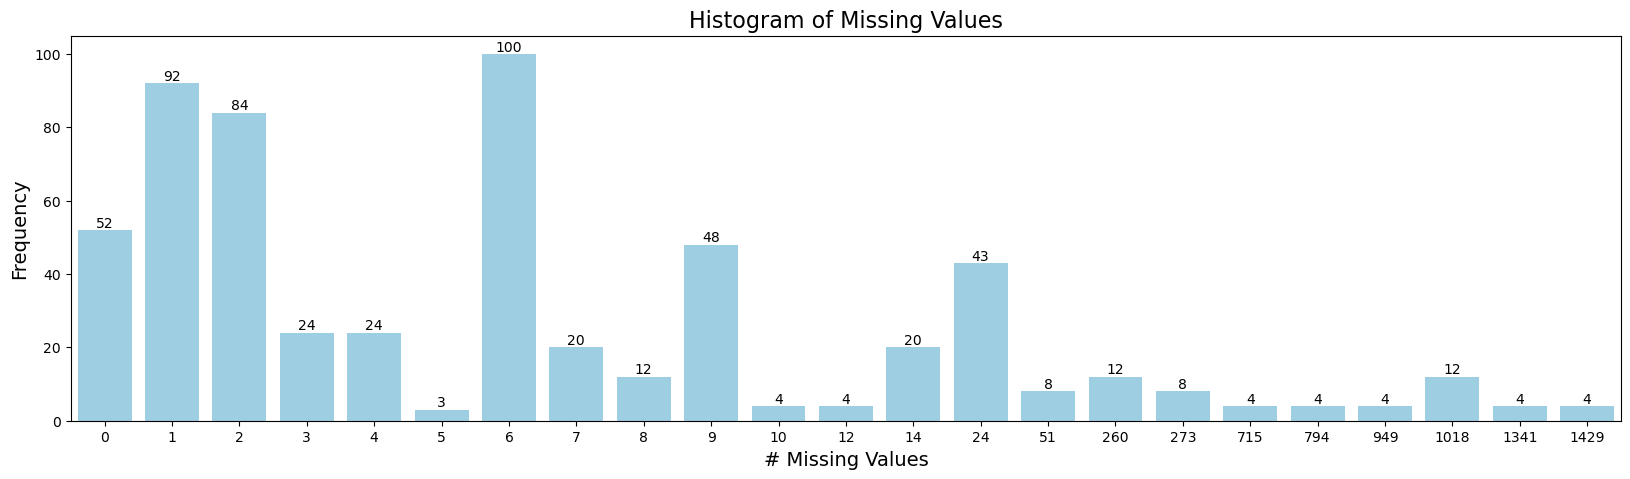

In [10]:
# Sort the missing value counts in descending order
missing_counts = missing.value_counts().sort_values(ascending=False)
# Plot the sorted histogram with axis labels
plt.figure(figsize=(20, 5))
ax = sns.barplot(x=missing_counts.index, y=missing_counts.values, alpha=0.9, color='skyblue')  # Set bar color to blue
plt.xlabel("# Missing Values", fontsize=14)  # Label for x-axis
plt.ylabel("Frequency", fontsize=14)        # Label for y-axis
plt.title("Histogram of Missing Values", fontsize=16)  # Title for the plot
# Add label markers above each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%d', fontsize=10)
plt.show()

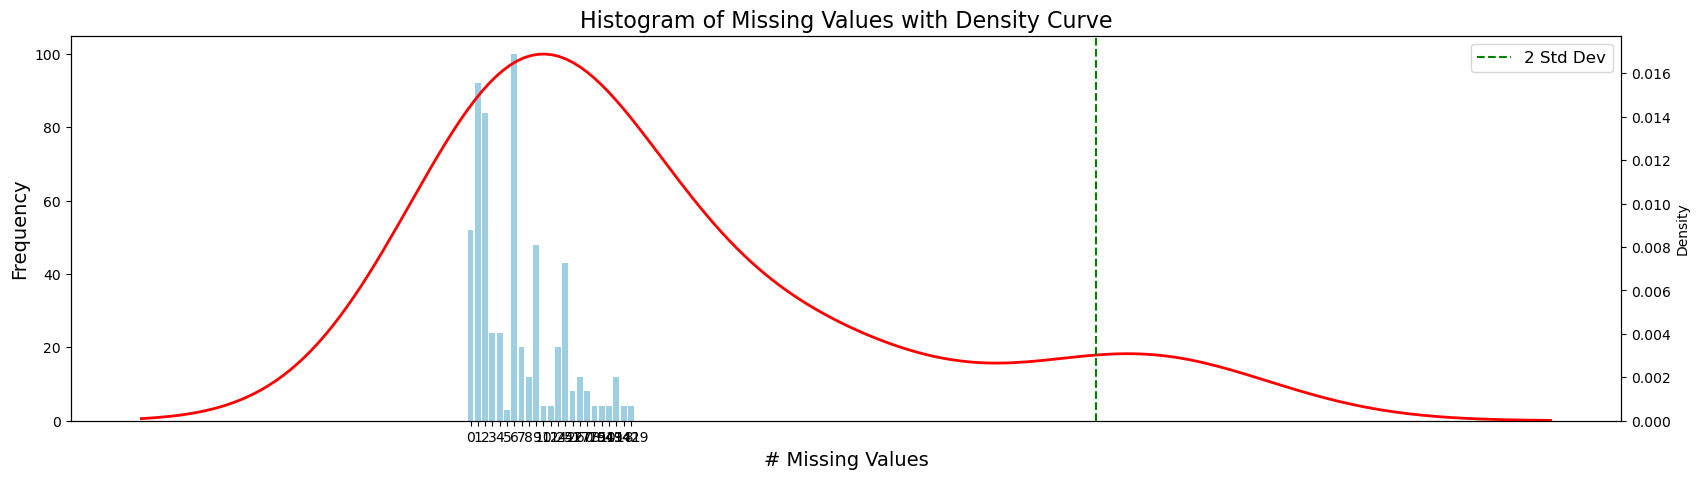

In [11]:
# Plot the histogram of missing values - DID NOT END UP USING THIS IN PRESENTATION DUE TO CURVE SHAPE
plt.figure(figsize=(20, 5))
ax = sns.barplot(x=missing_counts.index, y=missing_counts.values, alpha=0.9, color='skyblue')  # Set bar color to blue
plt.xlabel("# Missing Values", fontsize=14)  # Label for x-axis
plt.ylabel("Frequency", fontsize=14)        # Label for y-axis
plt.title("Histogram of Missing Values with Density Curve", fontsize=16)  # Title for the plot
# Plot the density curve
sns.kdeplot(missing_counts.values, color='red', linewidth=2, ax=ax.twinx())  # Use a secondary y-axis for the density curve
# Calculate the 2 standard deviation line
std_dev = missing_counts.std()
mean_value = missing_counts.mean()
two_std_line = mean_value + 2 * std_dev
# Add a vertical line at the 2 standard deviation mark
plt.axvline(x=two_std_line, color='green', linestyle='--', linewidth=1.5, label='2 Std Dev')
# Add legend
plt.legend(loc='upper right', fontsize=12)
plt.show()

In [12]:
# Calculate +3 and -3 standard deviations of missing VALUES to determine what % of missing values can be considered outliers and inform threshold for removal
plus_3_std = mean_value + 3 * std_dev
minus_3_std = mean_value - 3 * std_dev
print(f"+3 Standard Deviations: {plus_3_std}")
print(f"-3 Standard Deviations: {minus_3_std}")

+3 Standard Deviations: 115.82296048490468
-3 Standard Deviations: -64.51861265881774


In [13]:
#Analyze missing value basic counts and percentages (Avg Missing, Top 20% Pareto, Below 25% missing)
# Step 1: Calculate missing counts and missing percentages
missing_counts = data.isna().sum()
missing_percentage = (missing_counts / data.shape[0]) * 100  # 1567 rows
# Step 2: Basic counts
num_features_total = data.shape[1]
num_features_no_missing = (missing_counts == 0).sum()
num_features_25 = ((missing_counts > 0) & (missing_percentage < 25)).sum()
num_features_50 = ((missing_percentage >= 25) & (missing_percentage < 50)).sum()
num_features_half_missing = (missing_percentage >= 50).sum()
total_missing_values = data.isna().sum().sum()
total_missing_percentage = (total_missing_values / (data.shape[0] * data.shape[1])) * 100
print(f"Total features: {num_features_total}")
print(f"Features with NO missing values: {num_features_no_missing} ( {num_features_no_missing/num_features_total*100:.2f}% )")
print(f"Features with missing values between 0-25%: {num_features_25} ( {num_features_25/num_features_total*100:.2f}% )")
print(f"Features with missing values between 25-50%: {num_features_50} ( {num_features_50/num_features_total*100:.2f}% )")
print(f"Features with >=50% missing values: {num_features_half_missing} ( {num_features_half_missing/num_features_total*100:.2f}% )")
print(f"Total missing values in the 'data' dataset: {total_missing_values}")
# Step 3: Summary statistics
print("\nSummary of Missing Percentage:")
print(f"Minimum missing %: {missing_percentage.min():.2f}%")
print(f"Maximum missing %: {missing_percentage.max():.2f}%")
print(f"Mean missing %: {missing_percentage.mean():.2f}%")
print(f"Total percentage of missing values in the 'data' dataset: {total_missing_percentage:.2f}%")
print(f"Median missing %: {missing_percentage.median():.2f}%")
# Step 4: Top 10 features with most missingness
top_missing_features = missing_percentage.sort_values(ascending=False).head(10)
print("\nTop 10 features with highest missingness:")
print(top_missing_features)

Total features: 590
Features with NO missing values: 52 ( 8.81% )
Features with missing values between 0-25%: 506 ( 85.76% )
Features with missing values between 25-50%: 4 ( 0.68% )
Features with >=50% missing values: 28 ( 4.75% )
Total missing values in the 'data' dataset: 41951

Summary of Missing Percentage:
Minimum missing %: 0.00%
Maximum missing %: 91.19%
Mean missing %: 4.54%
Total percentage of missing values in the 'data' dataset: 4.54%
Median missing %: 0.38%

Top 10 features with highest missingness:
col158    91.193363
col293    91.193363
col294    91.193363
col159    91.193363
col493    85.577537
col359    85.577537
col86     85.577537
col221    85.577537
col247    64.964901
col110    64.964901
dtype: float64


In [14]:
#calculate 3s of missing PERCENT to determine what % of missing values can be considered outliers and inform threshold for removal
mean_missing_percentage = missing_percentage.mean()
std_missing_percentage = missing_percentage.std()
plus_3_std_missing_percentage = mean_missing_percentage + 3 * std_missing_percentage
minus_3_std_missing_percentage = mean_missing_percentage - 3 * std_missing_percentage
print(f"+3 Standard Deviations: {plus_3_std_missing_percentage}")
print(f"-3 Standard Deviations: {minus_3_std_missing_percentage}")

+3 Standard Deviations: 50.8395075614022
-3 Standard Deviations: -41.76440994423456


In [15]:
#calculate 4s of missing PERCENT to determine what % of missing values can be considered outliers and inform threshold for removal
mean_missing_percentage = missing_percentage.mean()
std_missing_percentage = missing_percentage.std()
plus_4_std_missing_percentage = mean_missing_percentage + 4 * std_missing_percentage
minus_4_std_missing_percentage = mean_missing_percentage - 4 * std_missing_percentage
print(f"+4 Standard Deviations: {plus_4_std_missing_percentage}")
print(f"-4 Standard Deviations: {minus_4_std_missing_percentage}")

+4 Standard Deviations: 66.27349381234166
-4 Standard Deviations: -57.19839619517402


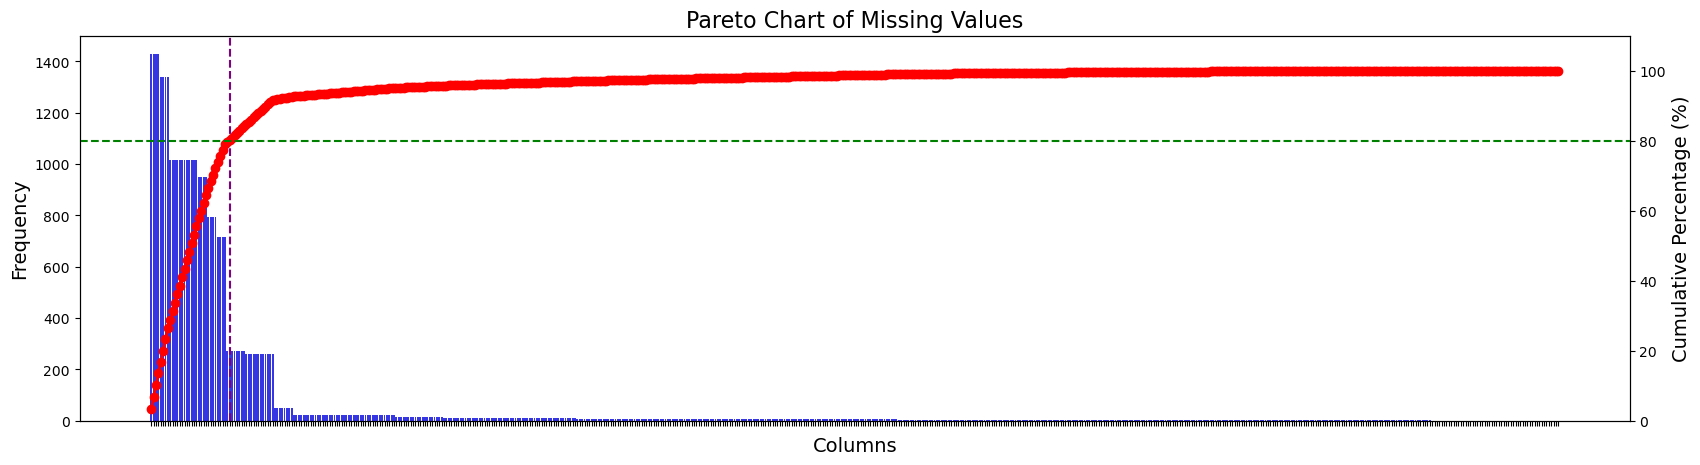

In [16]:
#Pareto Chart of Missing Values as a Count of Values
# # Calculate missing value counts and sort them in descending order
missing_counts = df.isna().sum().sort_values(ascending=False)
# Calculate cumulative percentage
cumulative_percentage = missing_counts.cumsum() / missing_counts.sum() * 100
# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(20, 5))
# Plot the bar chart for missing value counts
sns.barplot(x=missing_counts.index, y=missing_counts.values, alpha=0.9, ax=ax1, color='blue')
ax1.set_ylabel('Frequency', fontsize=14)
ax1.set_xlabel('Columns', fontsize=14)
ax1.set_title('Pareto Chart of Missing Values', fontsize=16)
# Create a second y-axis for the cumulative percentage
ax2 = ax1.twinx()
ax2.plot(missing_counts.index, cumulative_percentage, color='red', marker='o', linewidth=2)
ax2.set_ylabel('Cumulative Percentage (%)', fontsize=14)
ax2.set_ylim(0, 110)  # Ensure the percentage scale goes slightly above 100 for clarity
# Rotate x-axis labels for better readability
ax1.set_xticklabels([])
# Add horizontal line at 80% cumulative percentage
ax2.axhline(y=80, color='green', linestyle='--', linewidth=1.5)
# Find the column where the cumulative percentage exceeds 80%
threshold_index = cumulative_percentage[cumulative_percentage > 80].index[0]
# Add vertical line at the threshold column
ax1.axvline(x=threshold_index, color='purple', linestyle='--', linewidth=1.5)
plt.show()

In [17]:
# Combine missing counts and cumulative percentage into a DataFrame for better readability
missing_pct=missing_counts.values / df.shape[0] * 100
pareto_data = pd.DataFrame({
    'Column': missing_counts.index,
    'Missing %': missing_pct,
    'Cumulative Percentage': cumulative_percentage.values
})
# Remove any limit on number of displayed rows and columns
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)
# Now display the full DataFrame
pareto_data

,Column,Missing %,Cumulative Percentage
0,col158,91.193363,3.406355
1,col293,91.193363,6.812710
2,col294,91.193363,10.219065
3,col159,91.193363,13.625420
4,col493,85.577537,16.822007
...,...,...,...
587,col121,0.000000,100.000000
588,col157,0.000000,100.000000
589,col496,0.000000,100.000000
590,col495,0.000000,100.000000


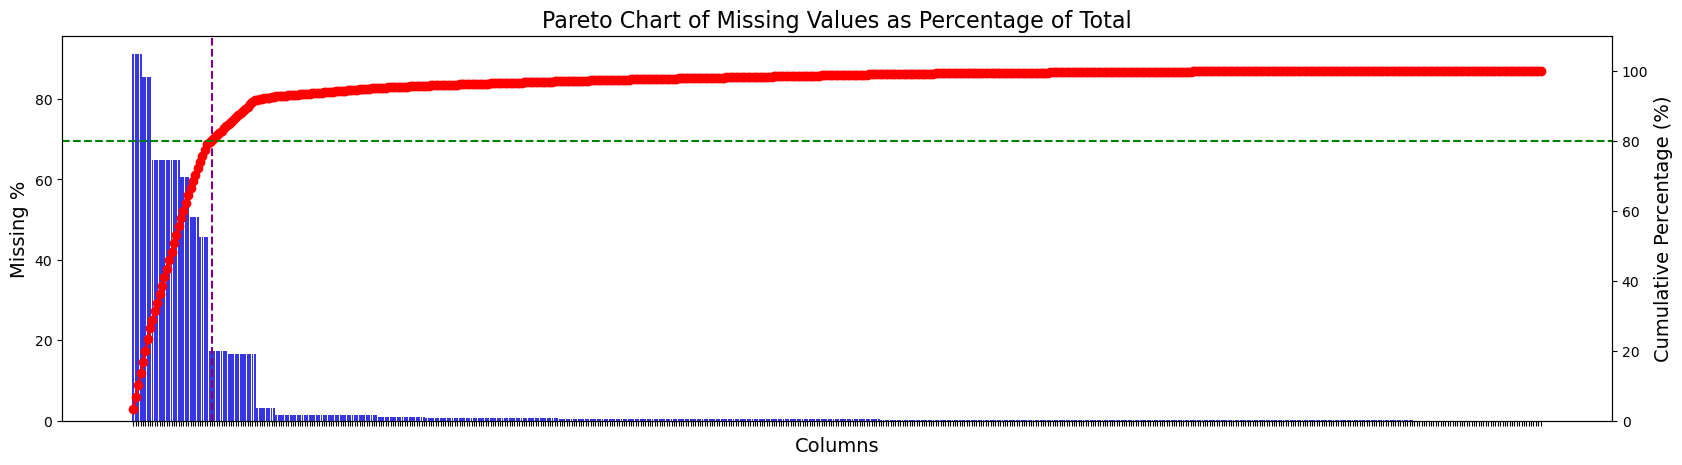

In [18]:
#Pareto Chart of Missing Values as a % of Total - USED IN PRESENTATION
# # Create a figure and axis
fig, ax1 = plt.subplots(figsize=(20, 5))
# Plot the bar chart for missing percentages
sns.barplot(x=pareto_data['Column'], y=pareto_data['Missing %'], alpha=0.9, ax=ax1, color='blue')
ax1.set_ylabel('Missing %', fontsize=14)
ax1.set_xlabel('Columns', fontsize=14)
ax1.set_title('Pareto Chart of Missing Values as Percentage of Total', fontsize=16)
# Create a second y-axis for the cumulative percentage
ax2 = ax1.twinx()
ax2.plot(pareto_data['Column'], pareto_data['Cumulative Percentage'], color='red', marker='o', linewidth=2)
ax2.set_ylabel('Cumulative Percentage (%)', fontsize=14)
ax2.set_ylim(0, 110)  # Ensure the percentage scale goes slightly above 100 for clarity
# Rotate x-axis labels for better readability
ax1.set_xticklabels([])
# Add horizontal line at 80% cumulative percentage
ax2.axhline(y=80, color='green', linestyle='--', linewidth=1.5)
# Find the column where the cumulative percentage exceeds 80%
threshold_column = pareto_data.loc[pareto_data['Cumulative Percentage'] > 80, 'Column'].iloc[0]
# Add vertical line at the threshold column
threshold_index = pareto_data[pareto_data['Column'] == threshold_column].index[0]
ax1.axvline(x=threshold_index, color='purple', linestyle='--', linewidth=1.5)
plt.show()

In [19]:
# Sort the DataFrame by 'Cumulative Percentage' in descending order
sorted_pareto_data = pareto_data.sort_values(by='Cumulative Percentage', ascending=False)
# Print the 'Missing %' and 'Cumulative Percentage' columns
print(sorted_pareto_data[['Missing %', 'Cumulative Percentage']])
# Identify columns with more than 65% missing values (change threshold per Tilo's comments from 60% to 65%)
missing_percentage = (missing_counts / data.shape[0]) * 100  # 1567 rows
columns_to_drop = missing_percentage[missing_percentage > 65].index
# Drop these columns from the dataset
data = data.drop(columns=columns_to_drop)
print(f"Removed {len(columns_to_drop)} columns with more than 65% missing values.")
print(f"Remaining columns: {data.shape[1]}")

     Missing %  Cumulative Percentage
591   0.000000             100.000000
564   0.000000             100.000000
562   0.000000             100.000000
561   0.000000             100.000000
560   0.000000             100.000000
..         ...                    ...
4    85.577537              16.822007
3    91.193363              13.625420
2    91.193363              10.219065
1    91.193363               6.812710
0    91.193363               3.406355

[592 rows x 2 columns]
Removed 8 columns with more than 65% missing values.
Remaining columns: 582


Duplicate Row Treatment - Remove 0 Features

In [20]:
#Check for duplicate rows (there are 0)
df.duplicated().sum()

0

Zero Variance Treatment - Remove 116 Features

In [21]:
#Zero volatility columns are those with 0 or near 0 mean and std
df.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,1561.0,3014.452896,73.621787,2743.2400,2966.260000,3011.4900,3056.6500,3356.3500
col2,1560.0,2495.850231,80.407705,2158.7500,2452.247500,2499.4050,2538.8225,2846.4400
col3,1553.0,2200.547318,29.513152,2060.6600,2181.044400,2201.0667,2218.0555,2315.2667
col4,1553.0,1396.376627,441.691640,0.0000,1081.875800,1285.2144,1591.2235,3715.0417
col5,1553.0,4.197013,56.355540,0.6815,1.017700,1.3168,1.5257,1114.5366
...,...,...,...,...,...,...,...,...
col587,1566.0,0.021458,0.012358,-0.0169,0.013425,0.0205,0.0276,0.1028
col588,1566.0,0.016475,0.008808,0.0032,0.010600,0.0148,0.0203,0.0799
col589,1566.0,0.005283,0.002867,0.0010,0.003300,0.0046,0.0064,0.0286
col590,1566.0,99.670066,93.891919,0.0000,44.368600,71.9005,114.7497,737.3048


In [22]:
# Identify columns with zero variance
zero_variance_columns = data.columns[data.std() == 0]
# Drop zero variance columns
data = data.drop(columns=zero_variance_columns)
print(f"Removed {len(zero_variance_columns)} columns with zero variance.")
print(f"Remaining columns: {data.shape[1]}")

Removed 116 columns with zero variance.
Remaining columns: 466


Low Variability Investigation - No Action

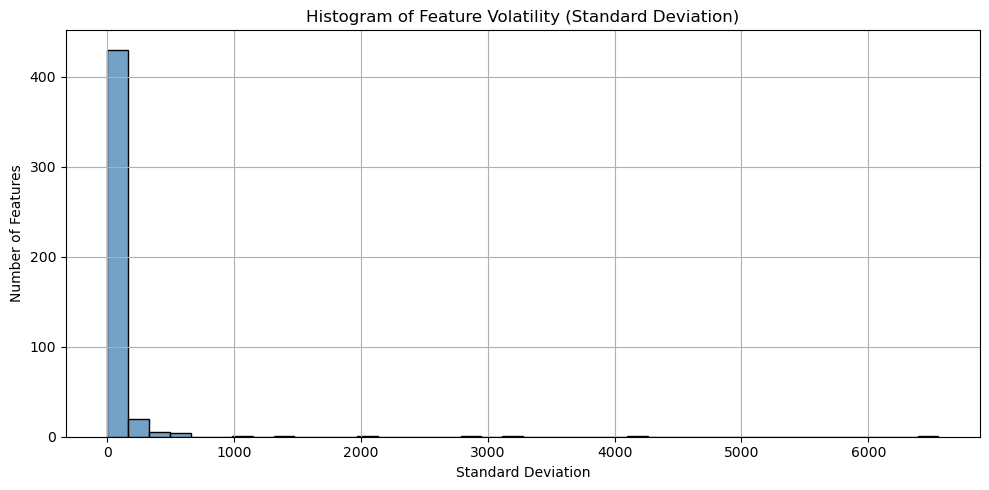

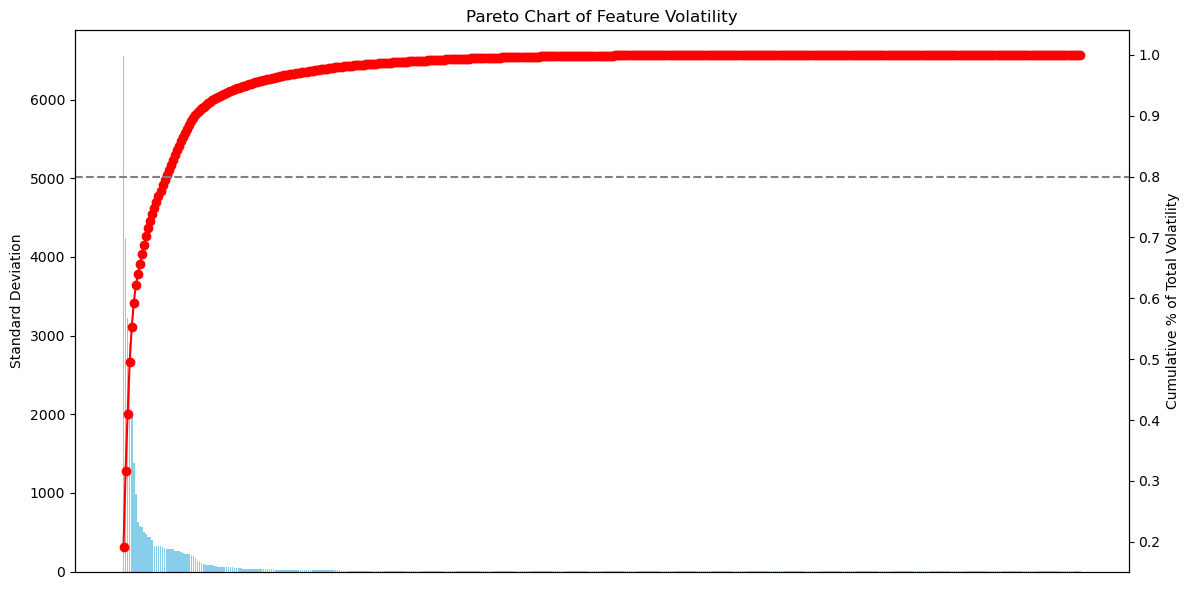

Number of features with low (but non-zero) volatility: 55
Percentage of features with low (but non-zero) volatility: 9.32%


In [23]:
# Calculate standard deviation (volatility) for each sensor column
std_devs = data.std().sort_values()
# ----------- Histogram of Feature Volatility -----------
plt.figure(figsize=(10, 5))
sns.histplot(std_devs, bins=40, kde=False, color='steelblue')
plt.title("Histogram of Feature Volatility (Standard Deviation)")
plt.xlabel("Standard Deviation")
plt.ylabel("Number of Features")
plt.grid(True)
plt.tight_layout()
plt.show()
# ----------- Pareto Chart of Feature Volatility -----------
# Sort in descending order for Pareto
sorted_std = std_devs[::-1]
cumulative = sorted_std.cumsum() / sorted_std.sum()
fig, ax1 = plt.subplots(figsize=(12, 6))
# Bar plot (standard deviation per column)
ax1.bar(sorted_std.index, sorted_std.values, color='skyblue')
ax1.set_ylabel('Standard Deviation')
ax1.set_xticks([])
ax1.set_title('Pareto Chart of Feature Volatility')
# Cumulative line plot
ax2 = ax1.twinx()
ax2.plot(cumulative.values, color='red', marker='o')
ax2.axhline(0.8, color='gray', linestyle='dashed')  # 80% line
ax2.set_ylabel('Cumulative % of Total Volatility')
plt.tight_layout()
plt.show()
# calculate low volatility features
# Calculate standard deviation excluding 'status' and 'timestamp'
std_devs = df.drop(columns=['status', 'timestamp']).std()
# Define a threshold for low volatility
low_volatility_threshold = 0.01
# Number of features with low but non-zero volatility
low_volatility_features = (std_devs > 0) & (std_devs < low_volatility_threshold)
# Calculate counts and percentages
num_low_volatility = low_volatility_features.sum()
percent_low_volatility = (num_low_volatility / len(std_devs)) * 100
print(f"Number of features with low (but non-zero) volatility: {num_low_volatility}")
print(f"Percentage of features with low (but non-zero) volatility: {percent_low_volatility:.2f}%")

Outlier Investigation - No Action

In [24]:
#note that the total outliers differs from ppt 1 because pp1 only removed zero volatility columns before calculating outliers; this version removes zero volatility AND >65% missing values. 
df_cleaned = data.copy()
# Calculate Z-scores
z_scores = (df_cleaned - df_cleaned.mean()) / df_cleaned.std()
# Define thresholds
thresholds = [3, 4]
for threshold in thresholds:
    # Identify outliers: where |Z| > threshold
    outliers = np.abs(z_scores) > threshold
    # Total outliers per row and count of rows with any outliers
    outliers_per_row = outliers.sum(axis=1)
    total_outlier_rows = (outliers_per_row > 0).sum()
    # Total outliers per column and count of columns with any outliers
    outliers_per_col = outliers.sum(axis=0)
    total_outlier_cols = (outliers_per_col > 0).sum()
    # Total outlier values in the dataset
    total_outliers = outliers.sum().sum()
    total_values = df_cleaned.size
    percent_outliers = (total_outliers / total_values) * 100
    # Print results
    print(f"\n--- Z-score threshold > {threshold} ---")
    print(f"Total rows with outliers: {total_outlier_rows} out of {df_cleaned.shape[0]} rows")
    print(f"Total columns with outliers: {total_outlier_cols} out of {df_cleaned.shape[1]} columns")
    print(f"Total outlier values: {total_outliers} out of {total_values} ({percent_outliers:.2f}%)")


--- Z-score threshold > 3 ---
Total rows with outliers: 1265 out of 1567 rows
Total columns with outliers: 433 out of 466 columns
Total outlier values: 6104 out of 730222 (0.84%)

--- Z-score threshold > 4 ---
Total rows with outliers: 761 out of 1567 rows
Total columns with outliers: 397 out of 466 columns
Total outlier values: 3251 out of 730222 (0.45%)


Correlation Investigation - No Action

In [25]:
#calculate standard deviation of column subsamples
print(f"Col1 Std: {data['col1'].std()}")
print(f"Col102 Std: {data['col102'].std()}")
print(f"Col64 Std: {data['col64'].std()}")

Col1 Std: 73.62178674853081
Col102 Std: 0.00022076237351255305
Col64 Std: 7.1198631082108985


In [26]:
data.head()

,col1,col2,col3,col4,col5,col7,col8,col9,col10,col11,col12,col13,col15,col16,col17,col18,col19,col20,col21,col22,col23,col24,col25,col26,col27,col28,col29,col30,col31,col32,col33,col34,col35,col36,col37,col38,col39,col40,col41,col42,col44,col45,col46,col47,col48,col49,col51,col52,col54,col55,col56,col57,col58,col59,col60,col61,col62,col63,col64,col65,col66,col67,col68,col69,col71,col72,col73,col74,col75,col76,col77,col78,col79,col80,col81,col82,col83,col84,col85,col87,col88,col89,col90,col91,col92,col93,col94,col95,col96,col97,col99,col100,col101,col102,col103,col104,col105,col106,col107,col108,col109,col110,col111,col112,col113,col114,col115,col116,col117,col118,col119,col120,col121,col122,col123,col124,col125,col126,col127,col128,col129,col130,col131,col132,col133,col134,col135,col136,col137,col138,col139,col140,col141,col143,col144,col145,col146,col147,col148,col149,col151,col152,col153,col154,col155,col156,col157,col160,col161,col162,col163,col164,col165,col166,col167,col168,col169,col170,col171,col172,col173,col174,col175,col176,col177,col178,col181,col182,col183,col184,col185,col186,col188,col189,col196,col197,col198,col199,col200,col201,col202,col203,col204,col205,col206,col207,col208,col209,col210,col211,col212,col213,col214,col215,col216,col217,col218,col219,col220,col222,col223,col224,col225,col226,col228,col229,col239,col240,col245,col246,col247,col248,col249,col250,col251,col252,col253,col254,col255,col256,col268,col269,col270,col271,col272,col273,col274,col275,col276,col278,col279,col280,col281,col282,col283,col284,col286,col287,col288,col289,col290,col291,col292,col295,col296,col297,col298,col299,col300,col301,col302,col303,col304,col305,col306,col307,col308,col309,col310,col311,col312,col313,col317,col318,col319,col320,col321,col322,col324,col325,col332,col333,col334,col335,col336,col337,col338,col339,col340,col341,col342,col343,col344,col345,col346,col347,col348,col349,col350,col351,col352,col353,col354,col355,col356,col357,col358,col360,col361,col362,col363,col364,col366,col367,col368,col369,col377,col378,col383,col384,col385,col386,col387,col388,col389,col390,col391,col392,col393,col394,col406,col407,col408,col409,col410,col411,col412,col413,col414,col416,col417,col418,col419,col420,col421,col422,col424,col425,col426,col427,col428,col429,col430,col431,col432,col433,col434,col435,col436,col437,col438,col439,col440,col441,col442,col443,col444,col445,col446,col447,col448,col449,col453,col454,col455,col456,col457,col458,col460,col461,col468,col469,col470,col471,col472,col473,col474,col475,col476,col477,col478,col479,col480,col481,col483,col484,col485,col486,col487,col488,col489,col490,col491,col492,col494,col495,col496,col497,col498,col500,col501,col511,col512,col517,col518,col519,col520,col521,col522,col523,col524,col525,col526,col527,col528,col540,col541,col542,col543,col544,col545,col546,col547,col548,col549,col550,col551,col552,col553,col554,col555,col556,col557,col558,col559,col560,col561,col562,col563,col564,col565,col566,col567,col568,col569,col570,col571,col572,col573,col574,col575,col576,col577,col578,col579,col580,col581,col582,col583,col584,col585,col586,col587,col588,col589,col590
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,97.6133,0.1242,1.5005,0.0162,-0.0034,0.9455,202.4396,7.9558,414.8710,10.0433,0.9680,192.3963,12.5190,1.4026,-5419.00,2916.50,-4043.75,751.00,0.8955,1.7730,3.0490,64.2333,2.0222,0.1632,3.5191,83.3971,9.5126,50.6170,64.2588,49.3830,66.3141,86.9555,117.5132,61.29,4.515,352.7173,10.1841,130.3691,723.3092,1.3072,141.2282,624.3145,218.3174,4.592,4.841,2834.0,0.9317,0.9484,4.7057,-1.7264,350.9264,10.6231,108.6427,16.1445,21.7264,29.5367,693.7724,0.9226,148.6009,608.1700,84.0793,NaN,NaN,0.0,0.0126,-0.0206,0.0141,-0.0307,-0.0083,-0.0026,-0.0567,-0.0044,7.2163,0.1320,2.3895,0.9690,1747.6049,0.1841,8671.9301,-0.3274,-0.0055,-0.0001,0.0001,0.0003,-0.2786,0.3974,-0.0251,0.0002,0.0002,0.1350,-0.0042,0.0003,0.0056,0.0000,-0.2468,0.3196,NaN,NaN,NaN,NaN,0.9460,0.0,748.6115,0.9908,58.4306,0.6002,0.

Text(0.5, 1.0, 'Single Digit SD Feature - Example 2 (col64)')

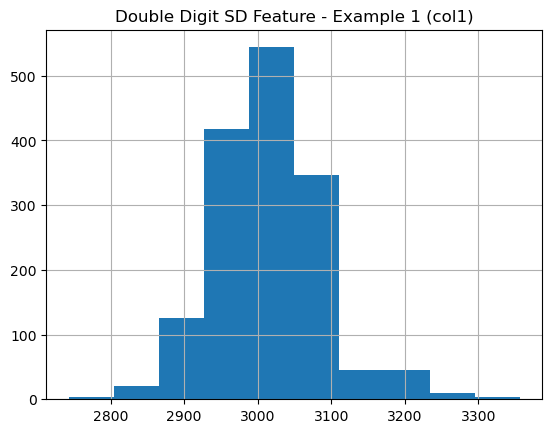

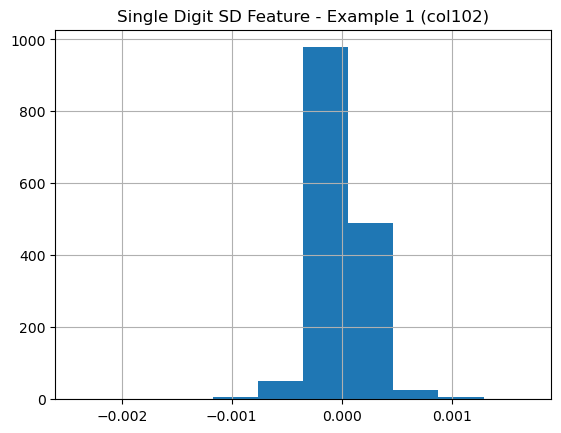

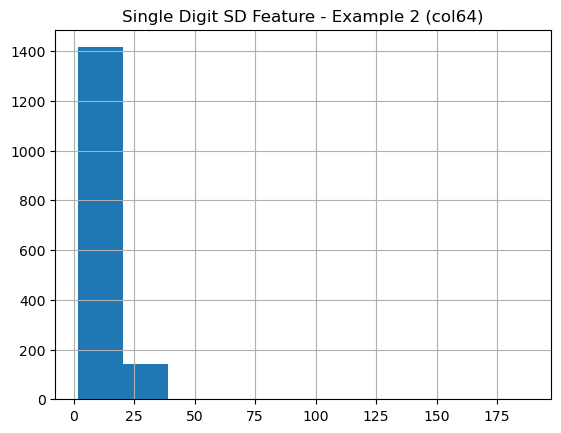

In [27]:
#Analyze histograms of a subsample of single digit SD vs double digit SD features to see if they are normally distributed
#double digit SD feature example
data[['col1']].hist()
plt.title('Double Digit SD Feature - Example 1 (col1)')
#single digit SD feature examples
data[['col102']].hist()
plt.title('Single Digit SD Feature - Example 1 (col102)')
data[['col64']].hist()
plt.title('Single Digit SD Feature - Example 2 (col64)')

['col163', 'col162', 'col298', 'col25', 'col297', 'col24', 'col160', 'col22', 'col161', 'col205', 'col141', 'col295']


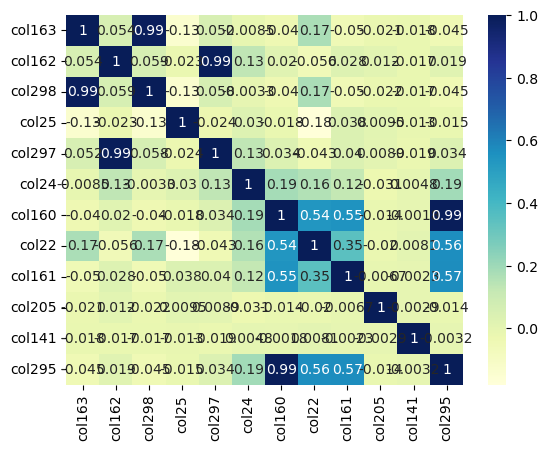

In [28]:
# Print the 12 columns with the highest standard deviation
top_12_std_cols = data.std().sort_values(ascending=False).head(12)
print(top_12_std_cols.index.tolist())
# Compute correlation matrix
corr_matrix_12= data[top_12_std_cols.index.tolist()].corr()
# Plot correlation heatmap
sns.heatmap(corr_matrix_12, cmap="YlGnBu", annot=True)
# Display heatmap
plt.show()

['col4', 'col226', 'col91', 'col512', 'col420', 'col500', 'col501', 'col68', 'col23', 'col419']


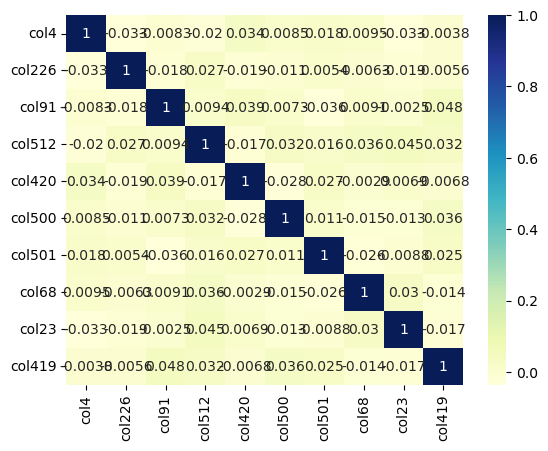

In [29]:
#print top standard deviation columns #12-22
std_sorted = data.std().sort_values(ascending=False)
top_12_22_std_cols = std_sorted.index[12:22].tolist()
print(top_12_22_std_cols)
# Plot correlation heatmap
corr_matrix_12_22 = data[top_12_22_std_cols].corr()
sns.heatmap(corr_matrix_12_22, cmap="YlGnBu", annot=True)
plt.show()

Lowest 10 double digit standard deviation columns:
col247    10.045084
col472    10.174117
col478    10.185026
col570    10.213294
col198    10.552162
col429    10.632730
col517    10.783880
col206    11.541083
col67     11.623078
col47     12.170315
dtype: float64


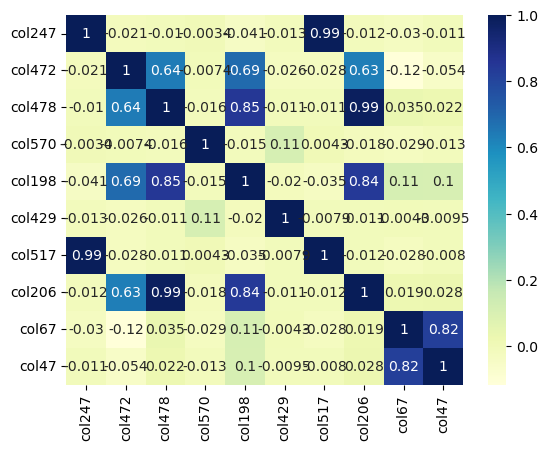

In [30]:
# Print the lowest 10 double digit standard deviation columns
# Find columns with double digit standard deviation (>=10 and <100)
double_digit_std = std_sorted[(std_sorted >= 10) & (std_sorted < 100)]
lowest_10_double_digit_std = double_digit_std[(double_digit_std >= 10) & (double_digit_std < 100)].sort_values().head(10)
print("Lowest 10 double digit standard deviation columns:")
print(lowest_10_double_digit_std)
#plot correlation heatmap of lowest 10 double digit standard deviation columns
corr_matrix_lowest_10_double_digit = data[lowest_10_double_digit_std.index].corr()
sns.heatmap(corr_matrix_lowest_10_double_digit, cmap="YlGnBu", annot=True)
plt.show()

Execute Train/Test Split

In [31]:
# Ensure the 'status' column is included in the split for stratification
data['status'] = labels['status']
# Perform the stratified split
train_data, test_data = train_test_split(
    data,
    test_size=0.2,
    stratify=data['status'],
    random_state=42
)
# Display the shapes of the resulting datasets
print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

Training data shape: (1253, 467)
Test data shape: (314, 467)


Describe Train/Test Split Distributions


📊 Label Distribution (Counts):
        Full Data  Train Data  Test Data
status                                  
-1           1463        1170        293
 1            104          83         21


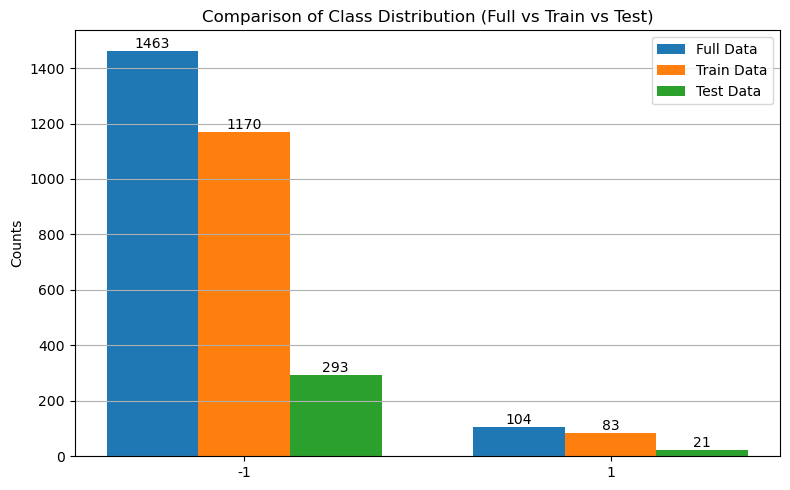

In [32]:
#summarize the distributions
full_counts = data['status'].value_counts().sort_index()
train_counts = train_data['status'].value_counts().sort_index()
test_counts = test_data['status'].value_counts().sort_index()
# Combine into a single table
distribution_table = pd.DataFrame({
    'Full Data': full_counts,
    'Train Data': train_counts,
    'Test Data': test_counts
})
print("\n📊 Label Distribution (Counts):")
print(distribution_table)
labels_list = distribution_table.index.tolist()
x = np.arange(len(labels_list))  # the label locations
width = 0.25  # width of the bars
fig, ax = plt.subplots(figsize=(8,5))
rects1 = ax.bar(x - width, distribution_table['Full Data'], width, label='Full Data')
rects2 = ax.bar(x, distribution_table['Train Data'], width, label='Train Data')
rects3 = ax.bar(x + width, distribution_table['Test Data'], width, label='Test Data')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Counts')
ax.set_title('Comparison of Class Distribution (Full vs Train vs Test)')
ax.set_xticks(x)
ax.set_xticklabels(labels_list)
ax.legend()
plt.grid(True, axis='y')
plt.tight_layout()
for container in ax.containers:
    ax.bar_label(container, fmt='%d', fontsize=10)
plt.show()

In [33]:
data.shape, train_data.shape, test_data.shape

((1567, 467), (1253, 467), (314, 467))

In [34]:
total_missing_values

41951

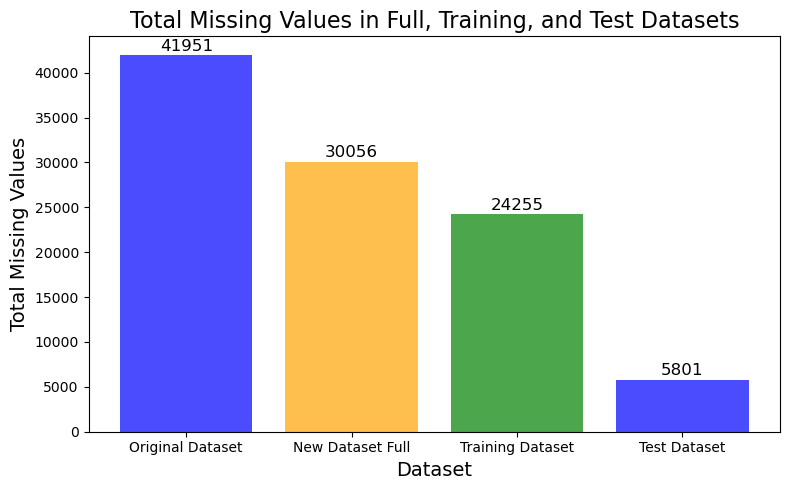

In [35]:
# Calculate the total number of missing values for each dataset
total_missing_full = data.isna().sum().sum()
total_missing_train = train_data.isna().sum().sum()
total_missing_test = test_data.isna().sum().sum()

# Create a bar plot
plt.figure(figsize=(8, 5))
datasets = ['Original Dataset', 'New Dataset Full', 'Training Dataset', 'Test Dataset']
missing_values = [total_missing_values, total_missing_full, total_missing_train, total_missing_test]
plt.bar(datasets, missing_values, color=['blue', 'orange', 'green'], alpha=0.7)
plt.xlabel('Dataset', fontsize=14)
plt.ylabel('Total Missing Values', fontsize=14)
plt.title('Total Missing Values in Full, Training, and Test Datasets', fontsize=16)

# Add value labels above the bars
for i, value in enumerate(missing_values):
    plt.text(i, value + 500, str(value), ha='center', fontsize=12)
plt.tight_layout()

plt.show()

Scale Train Data

In [36]:
#scale the data using robust scaler
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
train_data_scaled = scaler.fit_transform(train_data.drop(columns=['status']))
#convert the scaled data back to a dataframe   
train_data_scaled = pd.DataFrame(train_data_scaled, columns=train_data.drop(columns=['status']).columns)
train_data_scaled['status'] = train_data['status'].values
test_data_scaled = scaler.transform(test_data.drop(columns=['status']))
# Check the first few rows of the scaled training data
train_data_scaled.head()

,col1,col2,col3,col4,col5,col7,col8,col9,col10,col11,col12,col13,col15,col16,col17,col18,col19,col20,col21,col22,col23,col24,col25,col26,col27,col28,col29,col30,col31,col32,col33,col34,col35,col36,col37,col38,col39,col40,col41,col42,col44,col45,col46,col47,col48,col49,col51,col52,col54,col55,col56,col57,col58,col59,col60,col61,col62,col63,col64,col65,col66,col67,col68,col69,col71,col72,col73,col74,col75,col76,col77,col78,col79,col80,col81,col82,col83,col84,col85,col87,col88,col89,col90,col91,col92,col93,col94,col95,col96,col97,col99,col100,col101,col102,col103,col104,col105,col106,col107,col108,col109,col110,col111,col112,col113,col114,col115,col116,col117,col118,col119,col120,col121,col122,col123,col124,col125,col126,col127,col128,col129,col130,col131,col132,col133,col134,col135,col136,col137,col138,col139,col140,col141,col143,col144,col145,col146,col147,col148,col149,col151,col152,col153,col154,col155,col156,col157,col160,col161,col162,col163,col164,col165,col166,col167,col168,col169,col170,col171,col172,col173,col174,col175,col176,col177,col178,col181,col182,col183,col184,col185,col186,col188,col189,col196,col197,col198,col199,col200,col201,col202,col203,col204,col205,col206,col207,col208,col209,col210,col211,col212,col213,col214,col215,col216,col217,col218,col219,col220,col222,col223,col224,col225,col226,col228,col229,col239,col240,col245,col246,col247,col248,col249,col250,col251,col252,col253,col254,col255,col256,col268,col269,col270,col271,col272,col273,col274,col275,col276,col278,col279,col280,col281,col282,col283,col284,col286,col287,col288,col289,col290,col291,col292,col295,col296,col297,col298,col299,col300,col301,col302,col303,col304,col305,col306,col307,col308,col309,col310,col311,col312,col313,col317,col318,col319,col320,col321,col322,col324,col325,col332,col333,col334,col335,col336,col337,col338,col339,col340,col341,col342,col343,col344,col345,col346,col347,col348,col349,col350,col351,col352,col353,col354,col355,col356,col357,col358,col360,col361,col362,col363,col364,col366,col367,col368,col369,col377,col378,col383,col384,col385,col386,col387,col388,col389,col390,col391,col392,col393,col394,col406,col407,col408,col409,col410,col411,col412,col413,col414,col416,col417,col418,col419,col420,col421,col422,col424,col425,col426,col427,col428,col429,col430,col431,col432,col433,col434,col435,col436,col437,col438,col439,col440,col441,col442,col443,col444,col445,col446,col447,col448,col449,col453,col454,col455,col456,col457,col458,col460,col461,col468,col469,col470,col471,col472,col473,col474,col475,col476,col477,col478,col479,col480,col481,col483,col484,col485,col486,col487,col488,col489,col490,col491,col492,col494,col495,col496,col497,col498,col500,col501,col511,col512,col517,col518,col519,col520,col521,col522,col523,col524,col525,col526,col527,col528,col540,col541,col542,col543,col544,col545,col546,col547,col548,col549,col550,col551,col552,col553,col554,col555,col556,col557,col558,col559,col560,col561,col562,col563,col564,col565,col566,col567,col568,col569,col570,col571,col572,col573,col574,col575,col576,col577,col578,col579,col580,col581,col582,col583,col584,col585,col586,col587,col588,col589,col590,status
0,0.705503,-0.107758,-0.429691,-0.162177,-1.042097,0.650628,-0.592593,-0.593355,-0.722513,-0.088496,0.610687,0.888062,-1.561302,-1.021614,0.709715,1.190476,0.785278,1.091848,-0.189189,-0.192195,0.011470,-1.887532,-0.001228,-0.186565,0.469231,0.278684,1.746012,-0.298545,-0.562947,0.174734,-0.626450,-0.932168,0.015351,1.113780,-0.015346,-0.506271,-0.231499,-0.548522,0.733394,0.118716,0.783941,0.431168,-0.064004,0.432244,0.107916,0.514317,0.751078,0.064912,-0.818713,-1.192308,1.000000,-1.414013,0.814815,-0.398469,-0.461609,0.832669,0.723952,-0.257598,0.766920,0.351314,0.116565,0.464332,0.784280,-0.028710,0.296462,-0.214411,0.320239,0.127877,0.0,-0.010989,-0.677632,-0.658031,1.287805,-0.900415,-0.324468,0.632653,0.995495,0.360142,0.140625,0.337812,0.069620,-0.522785,-0.576985,-0.656919,-0.606486,0.903226,-0.269231,-1.0,1.

Impute Missing Values & Confirm Imputation Method

In [37]:
#mean imputation - Note: executed on NON-SCALED data
mean_imputed_w_outliers=train_data.fillna(train_data.mean())
#KNN Imputation using sklearn's KNNImputer
knn_imputer_w_outliers = KNNImputer(n_neighbors=5)
knn_imputed_w_outliers = pd.DataFrame(knn_imputer_w_outliers.fit_transform(train_data_scaled), columns=train_data_scaled.columns)
# MICE Imputation (Iterative Imputer from sklearn)
mice_imputer_w_outliers = IterativeImputer(max_iter=5, random_state=500)
mice_imputed_w_outliers = pd.DataFrame(mice_imputer_w_outliers.fit_transform(train_data_scaled), columns=train_data_scaled.columns)
#calculate variance for each imputed dataset. this is the mean but Tilo demonstrated it for each column. 
var_original_w_outliers = train_data_scaled.var().sum()
var_mean_w_outliers = mean_imputed_w_outliers.var().sum()
var_knn_w_outliers = knn_imputed_w_outliers.var().sum()
var_mice_w_outliers = mice_imputed_w_outliers.var().sum()
# Print SSD results. KNN has the closest variance to the original data, followed by MICE, then mean imputation.
print("\nVariances:")
print(f"Original Data: {var_original_w_outliers}")
print(f"Mean Imputation: {var_mean_w_outliers}")    
print(f"KNN Imputation: {var_knn_w_outliers}")
print(f"MICE Imputation: {var_mice_w_outliers}")


Variances:
Original Data: 117629435.0786987
Mean Imputation: 89248514.8381693
KNN Imputation: 117781535.9085474
MICE Imputation: 117815977.6428966


c:\Users\AparnaShenoyKankanad\anaconda3\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


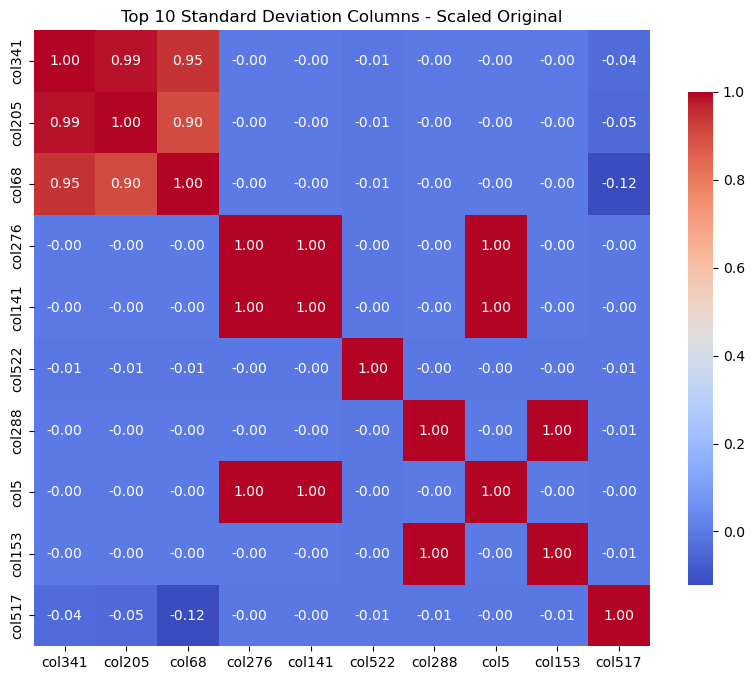

In [38]:
# validate imputation method chosen by looking at correlation heatmaps of each dataset
# #calculate standard deviation for each imputed dataset
std_original_w_outliers = train_data_scaled.std().mean()
#show a correlation heatmap of highest 10 standard deviation columns, correlated with each other
# Select the top 10 columns with the highest standard deviation
top_10_std_columns = train_data_scaled.std().nlargest(10).index
top_10_std_data = train_data_scaled[top_10_std_columns]
# Calculate the correlation matrix
correlation_matrix = top_10_std_data.corr()
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True, cbar_kws={"shrink": .8})
plt.title("Top 10 Standard Deviation Columns - Scaled Original")
plt.show()


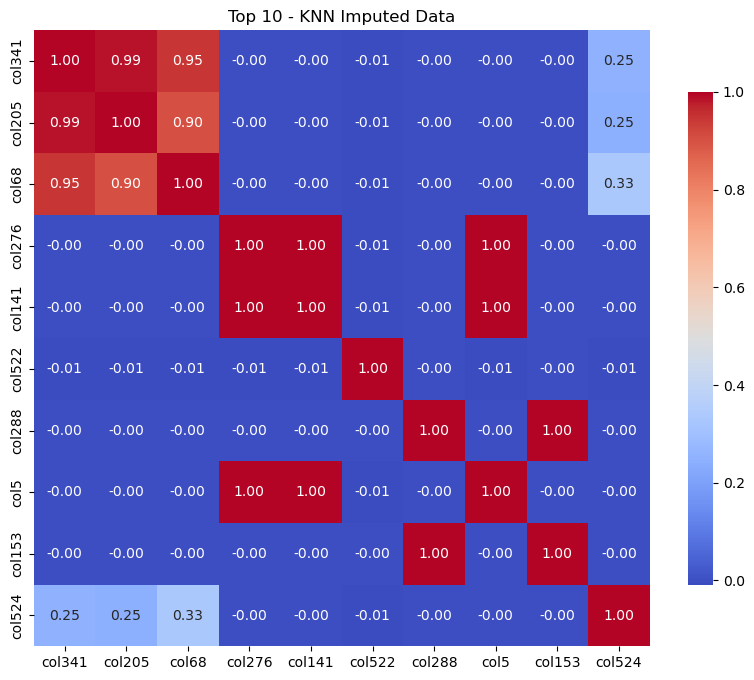

In [39]:
#calculate standard deviation for each imputed dataset
std_train_data_knn = knn_imputed_w_outliers.std().mean()
#show a correlation heatmap of highest 10 standard deviation columns, correlated with each other
# Select the top 10 columns with the highest standard deviation
top_10_std_columns_train_data_knn = knn_imputed_w_outliers.std().nlargest(10).index
top_10_std_data_train_data_knn = knn_imputed_w_outliers[top_10_std_columns_train_data_knn]
# Calculate the correlation matrix
correlation_matrix_train_data_knn = top_10_std_data_train_data_knn.corr()
# Plot the heatmap. KNN has closest correlation to the original data, followed by MICE, then mean imputation.
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_train_data_knn, annot=True, cmap='coolwarm', fmt=".2f", square=True, cbar_kws={"shrink": .8})
plt.title("Top 10 - KNN Imputed Data")
plt.show()

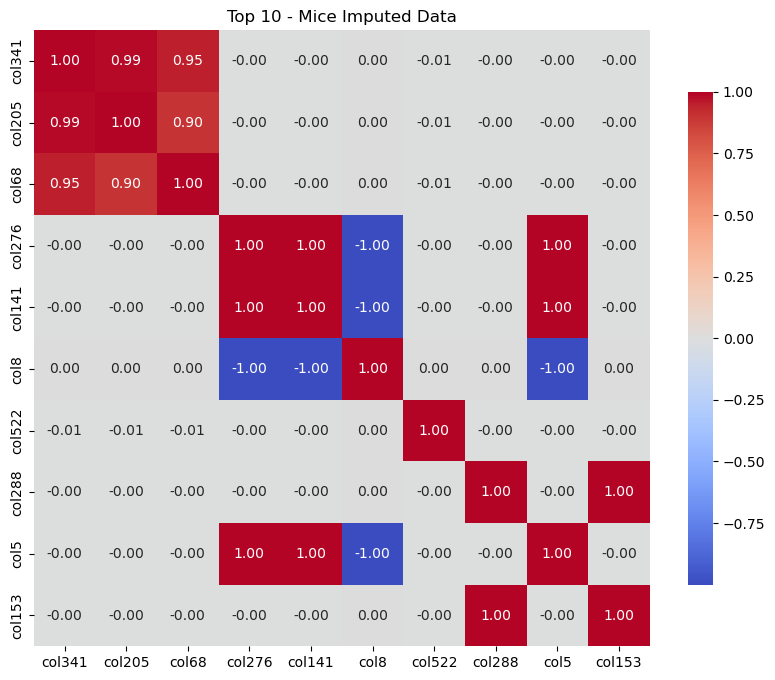

In [40]:
#calculate standard deviation for each imputed dataset
std_train_data_mice = mice_imputed_w_outliers.std().mean()
#show a correlation heatmap of highest 10 standard deviation columns, correlated with each other
# Select the top 10 columns with the highest standard deviation
top_10_std_columns_train_data_mice = mice_imputed_w_outliers.std().nlargest(10).index
top_10_std_data_train_data_mice = mice_imputed_w_outliers[top_10_std_columns_train_data_mice]
# Calculate the correlation matrix
correlation_matrix_train_data_mice = top_10_std_data_train_data_mice.corr()
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_train_data_mice, annot=True, cmap='coolwarm', fmt=".2f", square=True, cbar_kws={"shrink": .8})
plt.title("Top 10 - Mice Imputed Data")
plt.show()

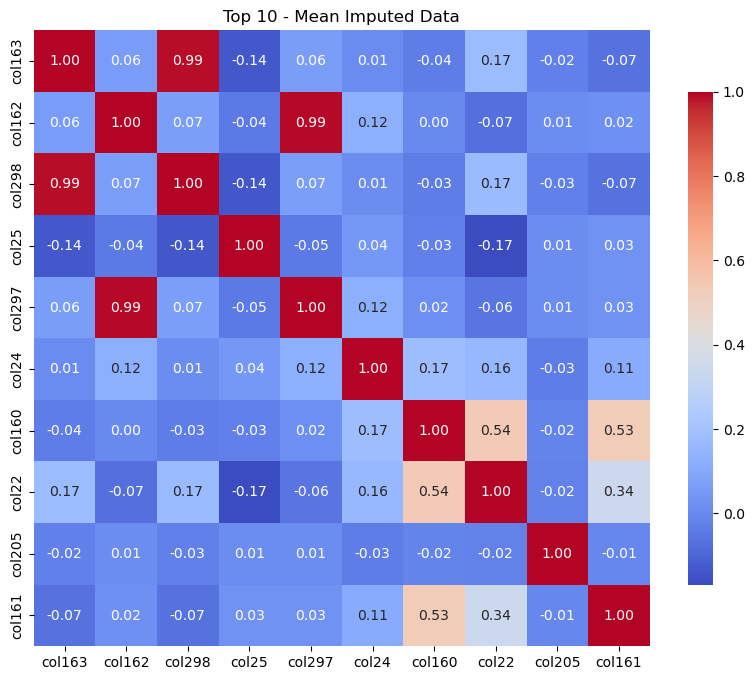

In [41]:
#calculate standard deviation for each imputed dataset
std_train_data_mean = mean_imputed_w_outliers.std().mean()
#show a correlation heatmap of highest 10 standard deviation columns, correlated with each other
# Select the top 10 columns with the highest standard deviation
top_10_std_columns_train_data_mean = mean_imputed_w_outliers.std().nlargest(10).index
top_10_std_data_train_data_mean = mean_imputed_w_outliers[top_10_std_columns_train_data_mean]
# Calculate the correlation matrix
correlation_matrix_train_data_mean = top_10_std_data_train_data_mean.corr()
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_train_data_mean, annot=True, cmap='coolwarm', fmt=".2f", square=True, cbar_kws={"shrink": .8})
plt.title("Top 10 - Mean Imputed Data")
plt.show()

In [42]:
correlation_matrix_train_data_mean

,col163,col162,col298,col25,col297,col24,col160,col22,col205,col161
col163,1.000000,0.058910,0.988191,-0.136669,0.059666,0.005476,-0.036161,0.169056,-0.024242,-0.067348
col162,0.058910,1.000000,0.066403,-0.043200,0.994634,0.124276,0.001754,-0.071178,0.013128,0.018777
col298,0.988191,0.066403,1.000000,-0.140133,0.067980,0.009914,-0.034334,0.166283,-0.025051,-0.068618
col25,-0.136669,-0.043200,-0.140133,1.000000,-0.045727,0.041562,-0.026992,-0.169196,0.010641,0.030164
col297,0.059666,0.994634,0.067980,-0.045727,1.000000,0.122075,0.015802,-0.058406,0.009602,0.028385
col24,0.005476,0.124276,0.009914,0.041562,0.122075,1.000000,0.174225,0.158143,-0.033866,0.109015
col160,-0.036161,0.001754,-0.034334,-0.026992,0.015802,0.174225,1.000000,0.535072,-0.016128,0.528819
col22,0.169056,-0.071178,0.166283,-0.169196,-0.058406,0.158143,0.535072,1.000000,-0.022722,0.338893
col205,-0.024242,0.013128,-0.025051,0.010641,0.009602,-0.033866,-0.016128,-0.022722,1.000000,-0.007894
col161,-0.067348,0.018777,-0.068618,0.030164,0.028385,0.109015,0.528819,0.338893,-0.007894,1.000000


In [43]:
# Compute the correlation matrix for train_data_knn (excluding 'status' if present)
corr_matrix_knn = knn_imputed_w_outliers.drop(columns=['status'], errors='ignore').corr()
# Select the upper triangle of the correlation matrix
upper_tri = corr_matrix_knn.where(np.triu(np.ones(corr_matrix_knn.shape), k=1).astype(bool))
# Find pairs with correlation higher than 0.9
high_corr_pairs = upper_tri.stack()[abs(upper_tri.stack()) > 0.9]
print("Correlation pairs with absolute value > 0.9:")
print(high_corr_pairs)

Correlation pairs with absolute value > 0.9:
col5    col141    0.999966
        col276    0.999967
        col414    0.916600
col17   col149    0.977556
        col153    0.983058
                    ...   
col580  col581    0.972361
col584  col585    0.995637
        col586    0.999908
col585  col586    0.996102
col588  col589    0.972768
Length: 414, dtype: float64
